In [ ]:
import pandas as pd
import numpy as np
import torch
import json
from normalizer import subSample, getDataFromJSON, trainer, getTotalAccuracy, tester, cfvalidation

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Change this to cuda for GPU enabled computers

## Load the data ##

In [2]:
# This file has 77270 data points. 71633 do not have NAN values.
# %time train1, labels1, weights1 = getDataFromJSON(path="data/train_partition1_data.json", earlyStop=-1)
train1, labels1 = subSample("data/train_partition1_data.json", device=device)

Now reading data/train_partition1_data.json
Now loading event 1/785
Now loading event 101/785
Now loading event 201/785
Now loading event 301/785
Now loading event 401/785
Now loading event 501/785
Now loading event 601/785
Now loading event 701/785
785 lines loaded.


In [3]:
# This file has 93767 data points. 82425 of them do not have NAN values.  
# %time train2, labels2, weights2 = getDataFromJSON(path="data/train_partition2_data.json", earlyStop=-1)
train2, labels2 = subSample("data/train_partition2_data.json", device=device)

Now reading data/train_partition2_data.json
Now loading event 1/300
Now loading event 101/300
Now loading event 201/300
300 lines loaded.


In [4]:
# This file has 42986 data points. 37759 of them do not have NAN values.  
# %time train3, labels3, weights3 = getDataFromJSON(path="data/train_partition3_data.json", earlyStop=-1)
train3, labels3 = subSample("data/train_partition3_data.json", device=device)

Now reading data/train_partition3_data.json
Now loading event 1/585
Now loading event 101/585
Now loading event 201/585
Now loading event 301/585
Now loading event 401/585
Now loading event 501/585
585 lines loaded.


In [5]:
train2[0,1]

tensor([0.0693, 0.0694, 0.0694, 0.0696, 0.0693, 0.0697, 0.0696, 0.0689, 0.0690,
        0.0689, 0.0688, 0.0685, 0.0689, 0.0692, 0.0696, 0.0696, 0.0695, 0.0693,
        0.0693, 0.0688, 0.0680, 0.0671, 0.0669, 0.0667, 0.0663, 0.0664, 0.0664,
        0.0666, 0.0659, 0.0657, 0.0651, 0.0649, 0.0650, 0.0663, 0.0667, 0.0668,
        0.0670, 0.0674, 0.0678, 0.0681, 0.0678, 0.0678, 0.0679, 0.0680, 0.0682,
        0.0684, 0.0690, 0.0689, 0.0689, 0.0693, 0.0691, 0.0692, 0.0697, 0.0699,
        0.0698, 0.0699, 0.0700, 0.0698, 0.0694, 0.0692])

In [6]:
train2[0,0]

tensor([0.0979, 0.0984, 0.0984, 0.0984, 0.0979, 0.1002, 0.1009, 0.0993, 0.0991,
        0.0988, 0.0982, 0.0994, 0.0994, 0.1009, 0.0996, 0.0983, 0.0981, 0.0979,
        0.0981, 0.0959, 0.0930, 0.0925, 0.0933, 0.0921, 0.0917, 0.0936, 0.0929,
        0.0957, 0.0949, 0.0963, 0.0969, 0.0948, 0.0961, 0.1017, 0.1055, 0.1060,
        0.1081, 0.1079, 0.1068, 0.1091, 0.1102, 0.1115, 0.1105, 0.1104, 0.1104,
        0.1123, 0.1163, 0.1141, 0.1147, 0.1149, 0.1135, 0.1131, 0.1144, 0.1126,
        0.1127, 0.1134, 0.1130, 0.1128, 0.1103, 0.1084])

## Define the network ##

In [7]:
# Define the network. Make sure to end with nn.Softmax activation
import torch.nn as nn
# from skorch import NeuralNet

class logRegWithHidden(nn.Module):
    def __init__(self, hidden_size1, hidden_size2, num_classes=5, drop1=.5, input_size=1980):
        super().__init__() 
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layerout = nn.Linear(hidden_size2, num_classes)
        #Define a RELU Activation unit
        self.relu = nn.ReLU()  
        self.smax = nn.Softmax(dim=1)
        self.drop = nn.Dropout(p=drop1)

    def forward(self, x):
        #Forward Propagate through the layers as defined above
        y = self.drop(x.reshape(-1, 1980))
        y = self.drop(self.relu(self.layer1(y)))
        y = self.relu(self.layer2(y))
        y = self.layerout(y)
        y = self.smax(y)
        return y



In [ ]:
ns = [4096*4,4096,1024]
hls = [4096*2, 2048, 512]
margs = []
for n in ns:
    for h in hls:
        margs.append([n,h])
lrs = [10**i for i in range(0,-5, -1)]
drs = [0, .17, .32, .5]
tripList = []
for ma in margs:
    for r in lrs:
        for d in drs:
            tripList.append([ma, {'drop1': d}, r])
lossArgs, quickArgs = cfvalidation(tripList, CNNinspired, train1, labels1, train2, labels2, train3, labels3, 200)
print(lossArgs, quickArgs, sep='\n')

## Adjust hyper parameters with 3 fold validation ##

In [8]:
modelArgs = [4096*4, 2048*4]
modelKwargs = {'drop1':.25}
trainKwargs = {'epochs':50, 'lr':0.0001}
# Attempted learning rates: 
# 0.0001 : one in a thousand change
# 0.00001 : one in TODO

The training loss for epoch 1/50 was 1.6095042088452507
The total balanced accuracy for validation was 0.2341880341880342
The validation loss was :   1/50 was 1.6090488236174625
The unbalanced validation accuracy is 0.2341880341880342
The accuracy for each is [1.0, 0.0, 0.0, 0.17094017094017094, 0.0]


=============End Epoch==============


The training loss for epoch 2/50 was 1.609286623842576
The total balanced accuracy for validation was 0.23247863247863249
The validation loss was :   2/50 was 1.6089208731284508
The unbalanced validation accuracy is 0.23247863247863249
The accuracy for each is [1.0, 0.0, 0.0, 0.1623931623931624, 0.0]


=============End Epoch==============


The training loss for epoch 3/50 was 1.6093182844274185
The total balanced accuracy for validation was 0.22905982905982905
The validation loss was :   3/50 was 1.6087923003058149
The unbalanced validation accuracy is 0.22905982905982905
The accuracy for each is [1.0, 0.0, 0.0, 0.1452991452991453, 0.0]


=========

The training loss for epoch 25/50 was 1.6065998778623694
The total balanced accuracy for validation was 0.21025641025641026
The validation loss was :   25/50 was 1.6060477026507385
The unbalanced validation accuracy is 0.21025641025641026
The accuracy for each is [1.0, 0.0, 0.0, 0.05128205128205128, 0.0]


=============End Epoch==============


The training loss for epoch 26/50 was 1.6062607484705307
The total balanced accuracy for validation was 0.21025641025641026
The validation loss was :   26/50 was 1.6059265540196346
The unbalanced validation accuracy is 0.21025641025641026
The accuracy for each is [1.0, 0.0, 0.0, 0.05128205128205128, 0.0]


=============End Epoch==============


The training loss for epoch 27/50 was 1.606649917714736
The total balanced accuracy for validation was 0.20854700854700856
The validation loss was :   27/50 was 1.605805867146223
The unbalanced validation accuracy is 0.20854700854700856
The accuracy for each is [1.0, 0.0, 0.0, 0.042735042735042736, 0.0]



The training loss for epoch 49/50 was 1.6039717828526217
The total balanced accuracy for validation was 0.20341880341880342
The validation loss was :   49/50 was 1.6031824723268167
The unbalanced validation accuracy is 0.20341880341880342
The accuracy for each is [1.0, 0.0, 0.0, 0.017094017094017096, 0.0]


=============End Epoch==============


The training loss for epoch 50/50 was 1.603757711017833
The total balanced accuracy for validation was 0.20341880341880342
The validation loss was :   50/50 was 1.603064218749348
The unbalanced validation accuracy is 0.20341880341880342
The accuracy for each is [1.0, 0.0, 0.0, 0.017094017094017096, 0.0]


=============End Epoch==============




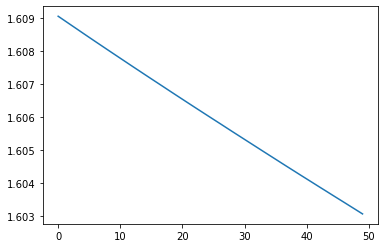

CPU times: user 1h 5min 34s, sys: 5min 41s, total: 1h 11min 16s
Wall time: 18min 13s


In [9]:
train1Args = [logRegWithHidden, torch.cat((train1, train2), dim=0), labels1 + labels2, None, train3, labels3, None]
%time train12 = trainer(*train1Args, *modelArgs, **trainKwargs, **modelKwargs)

The training loss for epoch 1/50 was 1.6096194819970564
The total balanced accuracy for validation was 0.36
The validation loss was :   1/50 was 1.6082851068178812
The unbalanced validation accuracy is 0.36
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.8]


=============End Epoch==============


The training loss for epoch 2/50 was 1.6091773022304883
The total balanced accuracy for validation was 0.36
The validation loss was :   2/50 was 1.6081017128626505
The unbalanced validation accuracy is 0.36
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.8]


=============End Epoch==============


The training loss for epoch 3/50 was 1.6091259934685447
The total balanced accuracy for validation was 0.35666666666666663
The validation loss was :   3/50 was 1.6079191001256308
The unbalanced validation accuracy is 0.3566666666666667
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.7833333333333333]


=============End Epoch==============


The training loss for epoch 4/50 was 1.6086100177331404
The

The training loss for epoch 26/50 was 1.6055082136934453
The total balanced accuracy for validation was 0.22333333333333333
The validation loss was :   26/50 was 1.6038569128513336
The unbalanced validation accuracy is 0.22333333333333333
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.11666666666666667]


=============End Epoch==============


The training loss for epoch 27/50 was 1.604989393190904
The total balanced accuracy for validation was 0.22333333333333333
The validation loss was :   27/50 was 1.6036853818098704
The unbalanced validation accuracy is 0.22333333333333333
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.11666666666666667]


=============End Epoch==============


The training loss for epoch 28/50 was 1.604903058572249
The total balanced accuracy for validation was 0.22333333333333333
The validation loss was :   28/50 was 1.6035139457384746
The unbalanced validation accuracy is 0.22333333333333333
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.11666666666666667]




The training loss for epoch 50/50 was 1.6019977710463784
The total balanced accuracy for validation was 0.21333333333333332
The validation loss was :   50/50 was 1.5997963778177897
The unbalanced validation accuracy is 0.21333333333333335
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.06666666666666667]


=============End Epoch==============




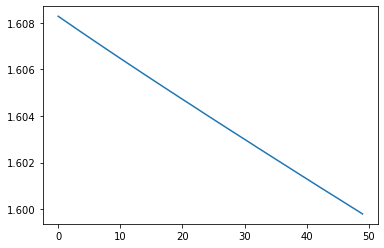

In [10]:
train13 = trainer(
    logRegWithHidden,
    torch.cat((train1, train3), dim=0),
    labels1 + labels3,
    None,
    train2,
    labels2,
    None,
    *modelArgs,
    **trainKwargs,
    **modelKwargs
)

The training loss for epoch 1/50 was 1.6094960570335388
The total balanced accuracy for validation was 0.19872611464968154
The validation loss was :   1/50 was 1.6089203113203596
The unbalanced validation accuracy is 0.19872611464968154
The accuracy for each is [0.0, 0.9936305732484076, 0.0, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 2/50 was 1.6088675515992301
The total balanced accuracy for validation was 0.2
The validation loss was :   2/50 was 1.6088244922601493
The unbalanced validation accuracy is 0.2
The accuracy for each is [0.0, 1.0, 0.0, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 3/50 was 1.6087413004466466
The total balanced accuracy for validation was 0.2
The validation loss was :   3/50 was 1.6087286168602621
The unbalanced validation accuracy is 0.2
The accuracy for each is [0.0, 1.0, 0.0, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 4/50 was 1.6086211034229823
The to

The training loss for epoch 29/50 was 1.60647314786911
The total balanced accuracy for validation was 0.2
The validation loss was :   29/50 was 1.6063024435833002
The unbalanced validation accuracy is 0.2
The accuracy for each is [0.0, 1.0, 0.0, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 30/50 was 1.6062114238739014
The total balanced accuracy for validation was 0.2
The validation loss was :   30/50 was 1.606210675664768
The unbalanced validation accuracy is 0.2
The accuracy for each is [0.0, 1.0, 0.0, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 31/50 was 1.6066476276942663
The total balanced accuracy for validation was 0.2
The validation loss was :   31/50 was 1.6061199505617665
The unbalanced validation accuracy is 0.2
The accuracy for each is [0.0, 1.0, 0.0, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 32/50 was 1.6060490608215332
The total balanced accuracy for validation was 0.

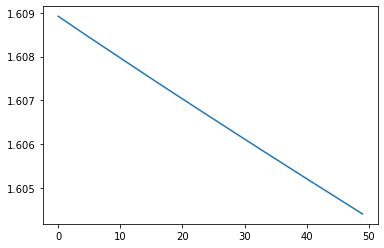

In [11]:
train23 = trainer(
    logRegWithHidden,
    torch.cat((train3, train2), dim=0),
    labels3 + labels2,
    None,
    train1,
    labels1,
    None,
    *modelArgs,
    **trainKwargs,
    **modelKwargs
)

In [12]:
acc = getTotalAccuracy(train12, train23, train13, 
                       torch.cat((train1, train2, train3), dim=0),
                      labels1 + labels2 + labels3)
print('Average accuracy of all three models on all data: ', acc)

Average accuracy of all three models on all data:  0.20139720558882235


## Final model creation for testing ##

Once acceptable hyperparameters have been established, run this code to train on all the data and print out a CSV that predicts from the test data.

The training loss for epoch 1/50 was 1.6076555472833138
The total balanced accuracy for validation was 0.24371257485029937
The validation loss was :   1/50 was 1.6081288628235548
The unbalanced validation accuracy is 0.2437125748502994
The accuracy for each is [0.32335329341317365, 0.0, 0.8922155688622755, 0.0029940119760479044, 0.0]


=============End Epoch==============


The training loss for epoch 2/50 was 1.6073362429936726
The total balanced accuracy for validation was 0.25389221556886227
The validation loss was :   2/50 was 1.6079272088890304
The unbalanced validation accuracy is 0.25389221556886227
The accuracy for each is [0.40119760479041916, 0.0, 0.8652694610778443, 0.0029940119760479044, 0.0]


=============End Epoch==============


The training loss for epoch 3/50 was 1.6074187843887895
The total balanced accuracy for validation was 0.29221556886227545
The validation loss was :   3/50 was 1.6077276601762829
The unbalanced validation accuracy is 0.29221556886227545
The accu

The total balanced accuracy for validation was 0.21437125748502991
The validation loss was :   24/50 was 1.6036921423352408
The unbalanced validation accuracy is 0.21437125748502994
The accuracy for each is [1.0, 0.0, 0.0718562874251497, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 25/50 was 1.6034024909690574
The total balanced accuracy for validation was 0.21017964071856285
The validation loss was :   25/50 was 1.6035047504002462
The unbalanced validation accuracy is 0.21017964071856288
The accuracy for each is [1.0, 0.0, 0.05089820359281437, 0.0, 0.0]


=============End Epoch==============


The training loss for epoch 26/50 was 1.6036051070248638
The total balanced accuracy for validation was 0.20598802395209578
The validation loss was :   26/50 was 1.6033186345043298
The unbalanced validation accuracy is 0.2059880239520958
The accuracy for each is [1.0, 0.0, 0.029940119760479042, 0.0, 0.0]


=============End Epoch==============


The training loss

The training loss for epoch 50/50 was 1.5997702722196225
The total balanced accuracy for validation was 0.2
The validation loss was :   50/50 was 1.5989493370056151
The unbalanced validation accuracy is 0.2
The accuracy for each is [1.0, 0.0, 0.0, 0.0, 0.0]


=============End Epoch==============




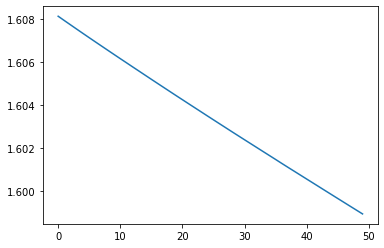

In [13]:
train123 = trainer(
    logRegWithHidden,
    torch.cat((train1, train2, train3), dim=0),
    labels1 + labels2 + labels3,
    None,
    torch.cat((train1, train2, train3), dim=0),
    labels1 + labels2 + labels3,
    None,
    *modelArgs,
    **trainKwargs,
    **modelKwargs
)

In [14]:
from datetime import datetime
def tester(model, pathToWrite=None):
    if pathToWrite is None:
        pathToWrite = f'results/submission{datetime.now().strftime("%d_%H:%M")}.csv'
    # Get test data
    test, ids, _ = getDataFromJSON(path='data/test_4_5_data.json', test=True, device=device)
    # get our guesses from the network
    guesses = torch.argmax(model(test))
    assert len(ids) == guesses.shape
    # Open a file to write to
    file = open(pathToWrite, mode='w')
    print('Id,Label', file=file)
    for i in range(len(ids)):
        print(ids[i], guesses[i], sep=',', file=file)
    file.close()

tester(train123)

Now reading data/test_4_5_data.json


KeyError: 'u'

In [ ]:
from datetime import datetime
acc = 
PATH = f'savedModels/lr{lr}acc{acc}time{datetime.now().strftime("%d_%H:%M")}.pth'
torch.save(newModel.state_dict(), PATH)
print('REMEMBER TO DELETE YOUR ACCURACY SO THE NEXT PERSON REMEMBERS TO WRITE THEIRS')